In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from wind_dir_classifier import load_netcdf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

<frozen importlib._bootstrap>:241: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [2]:
df = load_netcdf('C:/Studia/maciej-romanski/data/gaj_olawski')

c:\Studia\maciej-romanski\wind_dir_classifier.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(netCDF2df(path+'/'+filename),ignore_index=True)


In [3]:
series = df['windspeed_100'].to_numpy()

In [4]:
def rmse(y_pred, y_true):
    return np.sqrt(np.mean((y_pred - y_true)**2))

Moving Avarage (MA):

1.4631170946504235


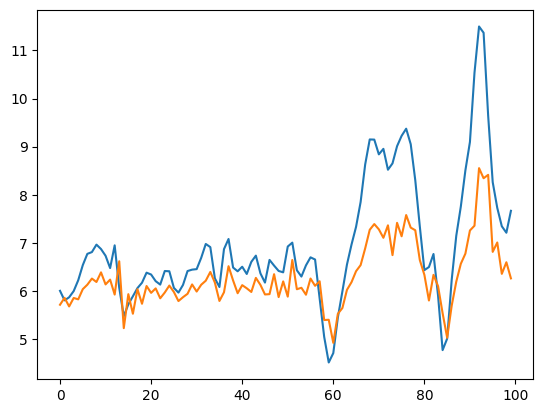

In [8]:
model = ARIMA(series, order=(0,0,1))
model_fit = model.fit()
yhat = model_fit.predict(0, len(series)-1)
plt.plot(series[:100])
plt.plot(yhat[:100])
print(rmse(yhat, series))

In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, 
 window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean
 
    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'AR':
        pred_AR = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(3,0,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_AR.extend(oos_pred)
            
        return pred_AR

In [ ]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX
 
def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:

    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

from itertools import product
 
ps = range(0, 4, 1)
qs = range(0, 4, 1)
 
order_list = list(product(ps, qs))

result_df = optimize_ARMA(ARMA_1_1, order_list)
